### Load the data for the first time

In [1]:
## fill nas with median
## very rude transformation of dates
## test/train split
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# import missingno as msno
import pickle
from sklearn import preprocessing
from sklearn.metrics import roc_curve
# from fancyimpute import *
from sklearn.model_selection import StratifiedKFold as SKF
from xgboost import *

%matplotlib inline

In [2]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

def batch_save(train_x, train_y, valid_x, valid_y, test, postfix):
    train_x.reset_index().to_feather("tmp/train_x_{}".format(postfix))
    train_y.reset_index().to_feather("tmp/train_y_{}".format(postfix))
    valid_x.reset_index().to_feather("tmp/valid_x_{}".format(postfix))
    valid_y.reset_index().to_feather("tmp/valid_y_{}".format(postfix))
    test.reset_index().to_feather("tmp/test_{}".format(postfix))
    
def batch_load(postfix):
    train_x = pd.read_feather("tmp/train_x_{}".format(postfix))
    train_y = pd.read_feather("tmp/train_y_{}".format(postfix))
    valid_x = pd.read_feather("tmp/valid_x_{}".format(postfix))
    valid_y = pd.read_feather("tmp/valid_y_{}".format(postfix))
    return train_x, train_y, valid_x, valid_y

def my_roc(y_true, y_prob):
    if isinstance(y_true,pd.core.series.Series):
        y_true = np.array(y_true.tolist())
    if isinstance(y_true,list):
        y_true = np.array(y_true)
    sort_index = np.argsort(y_prob)[::-1]
    y_prob = y_prob[sort_index]
    y_true = y_true[sort_index]
    num_p = y_true.sum()
    num_n = len(y_true) - num_p
    fp = 0
    tp = 0
    fps = []
    tps = []
    prob_prev = -99
    i = 0
    while i < len(y_true):
        if y_prob[i]!=prob_prev:
            fps.append(fp/num_n)
            tps.append(tp/num_p)
            prob_prev=y_prob[i]
        if y_true[i]==1:
            tp+=1
        else:
            fp+=1
        i+=1
    fps.append(fp/num_n)
    tps.append(tp/num_p)
    return np.array(fps), np.array(tps)

# def find_point(t, tpr, fpr):
#     if (fpr==t).argmax()!=0:
#         return tpr[(fpr>=t).argmax()]
#     else:
#         y_2 = tpr[(fpr>t).argmax()]
#         y_1 = tpr[(fpr>t).argmax()-1]
#         x_2 = fpr[(fpr>t).argmax()]
#         x_1 = fpr[(fpr>t).argmax()-1]
#         return ((y_2-y_1)*0.01-x_1*y_2+x_2*y_1)/(x_2-x_1)

# def my_score1(y_prob, xtrain): ##My own version
#     y_true = xtrain.get_label()
#     fpr, tpr = roc_curve(y_true,y_prob)
#     # plt.scatter(fpr, tpr)
#     # plt.show()
#     return 'score', (0.4*find_point(0.001, tpr, fpr)+0.3*find_point(0.005, tpr, fpr)+0.3*find_point(0.01, tpr, fpr))

# def my_score2(y_prob, y_true): ##My own version
#     fpr, tpr = my_roc(y_true,y_prob)
#     plt.scatter(fpr, tpr)
#     plt.show()  
#     return 'score', (0.4*find_point(0.001, tpr, fpr)+0.3*find_point(0.005, tpr, fpr)+0.3*find_point(0.01, tpr, fpr))

def my_score3(predictions, xtrain): ##Adapted from SKlearn, conservative (actual should be higher)
    ground_truth = y_true = xtrain.get_label()
    fpr,tpr = my_roc(ground_truth, predictions)
    tpr1 = tpr[(fpr>=0.001).argmax()-1]
    tpr2 = tpr[(fpr>=0.005).argmax()-1] 
    tpr3 = tpr[(fpr>=0.01).argmax()-1]
    return 'score', 0.4 * tpr1 + 0.3 * tpr2 + 0.3* tpr3

In [3]:
dtype = load_obj('dict_dtype')
my_dict = load_obj('my_dict')

In [4]:
data = pd.read_csv("atec_anti_fraud_train.csv",parse_dates=['date'], dtype = dtype)
test = pd.read_csv("atec_anti_fraud_test_a.csv",parse_dates=['date'], dtype = dtype)

In [5]:
# temporially ignore the rows without labels
data = data[data['label']!=-1]

In [ ]:
data.sort_values('date',inplace=True)

In [ ]:
# df_whole = load_obj('df_whole')

In [ ]:
# array_before_filled = load_obj('array_before_filled')

# filled = MICE().complete(array_before_filled)

In [ ]:
# data = pd.read_csv("atec_anti_fraud_train.csv",parse_dates=['date'])
# test = pd.read_csv("atec_anti_fraud_test_a.csv",parse_dates=['date'])
# df_whole = pd.concat([data.iloc[:,3:], test.iloc[:,2:]])
# info = df_whole.describe()
# dtype = dict()
# null_cols = df_whole.columns[df_whole.isnull().any()].tolist()
# for i in range(1,298):
#     colName = 'f'+str(i)
#     if info[colName][7]<=64:
#         if colName not in null_cols:
#             dtype[colName] = np.int8
#         else:
#             dtype[colName] = np.float16
#     elif info[colName][7]<=32767:
#         if colName not in null_cols:
#             dtype[colName] = np.int16
#         else:
#             dtype[colName] = np.float32
#     else:
#         if colName not in null_cols:
#             dtype[colName] = np.int32
#         else:
#             dtype[colName] = np.float64
# save_obj(dtype, 'dict_dtype')

In [ ]:
# for col in data.columns[3:]:
#     print('=======>   '+col+ '   <======')
#     print(data[col].unique())

# np.intersect1d(data.id.values, test.id.values)

### cv xgboost

In [6]:
NFOLDS = 5
kfold = SKF(n_splits=NFOLDS, shuffle=False)#, random_state=666)

In [7]:
train_id = data['id']
test_id = test['id']
y = data['label'].values
X = data.drop(['id','date','label'], axis=1).values
X_test = test.drop(['id','date'], axis=1).values

In [8]:
print(X.shape, y.shape, X_test.shape)

(990006, 297) (990006,) (491668, 297)


In [11]:
# set up the parameters
params = {'max_depth': 8, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
params['nthread'] = 4
params['eval_metric'] = ['auc']
params["scale_pos_weight"] = 3
params["colsample_bytree "] = 0.8
num_rounds = 300
early_stopping_rounds = 20

# set up the random seed for testing
params["seed"] = 6

In [12]:
# cv_train = np.zeros(len(train_id))
cv_pred = np.zeros(len(test_id))
xgtest = xgb.DMatrix(X_test)

kf = kfold.split(X, y)

for i, (train_idx, val_idx) in enumerate(kf):
    X_train, X_validate, label_train, label_validate = \
    X[train_idx,:], X[val_idx,:], y[train_idx], y[val_idx]
    xgtrain = xgb.DMatrix(X_train, label_train)
    xgvalid = xgb.DMatrix(X_validate, label_validate)
    evallist = [(xgtrain, 'train'), (xgvalid, 'valid')]
    bst = xgb.train(params,
                    xgtrain,
                    num_rounds,
                    evallist,
                    #feval=my_score3,
                    early_stopping_rounds=early_stopping_rounds)
    
    cv_pred += bst.predict(xgtest, ntree_limit=bst.best_iteration)
    
cv_pred /= NFOLDS

[0]	train-auc:0.960182	valid-auc:0.93386
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.962521	valid-auc:0.936472
[2]	train-auc:0.966741	valid-auc:0.941576
[3]	train-auc:0.97113	valid-auc:0.947822
[4]	train-auc:0.971619	valid-auc:0.948857
[5]	train-auc:0.971859	valid-auc:0.949224
[6]	train-auc:0.971992	valid-auc:0.94929
[7]	train-auc:0.977032	valid-auc:0.949922
[8]	train-auc:0.977184	valid-auc:0.950021
[9]	train-auc:0.977539	valid-auc:0.949984
[10]	train-auc:0.978106	valid-auc:0.948806
[11]	train-auc:0.978261	valid-auc:0.949093
[12]	train-auc:0.980326	valid-auc:0.950741
[13]	train-auc:0.980702	valid-auc:0.951131
[14]	train-auc:0.981002	valid-auc:0.951463
[15]	train-auc:0.981163	valid-auc:0.951776
[16]	train-auc:0.984033	valid-auc:0.960941
[17]	train-auc:0.986441	valid-auc:0.96455
[18]	train-auc:0.986633	valid-auc:0.965005
[19]	train-auc:0.98725	valid-auc:0.968278
[20]	train-a

[89]	train-auc:0.99644	valid-auc:0.987788
[90]	train-auc:0.996475	valid-auc:0.987772
[91]	train-auc:0.99648	valid-auc:0.987741
[92]	train-auc:0.996501	valid-auc:0.987765
[93]	train-auc:0.996523	valid-auc:0.987739
[94]	train-auc:0.996563	valid-auc:0.98779
[95]	train-auc:0.996568	valid-auc:0.987787
[96]	train-auc:0.996626	valid-auc:0.987798
[97]	train-auc:0.996629	valid-auc:0.987822
[98]	train-auc:0.996638	valid-auc:0.987716
[99]	train-auc:0.996657	valid-auc:0.987691
[100]	train-auc:0.996669	valid-auc:0.987699
[101]	train-auc:0.996723	valid-auc:0.987722
[102]	train-auc:0.996736	valid-auc:0.987732
[103]	train-auc:0.996809	valid-auc:0.987691
[104]	train-auc:0.996821	valid-auc:0.987712
Stopping. Best iteration:
[84]	train-auc:0.996314	valid-auc:0.98792

[0]	train-auc:0.954785	valid-auc:0.954647
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.956193	valid-auc:0.956401
[2]	train-auc:

[49]	train-auc:0.99249	valid-auc:0.987298
[50]	train-auc:0.992587	valid-auc:0.987319
[51]	train-auc:0.99301	valid-auc:0.987651
[52]	train-auc:0.993451	valid-auc:0.987848
[53]	train-auc:0.993548	valid-auc:0.987899
[54]	train-auc:0.993691	valid-auc:0.987887
[55]	train-auc:0.993925	valid-auc:0.987936
[56]	train-auc:0.994201	valid-auc:0.988088
[57]	train-auc:0.994352	valid-auc:0.988325
[58]	train-auc:0.994477	valid-auc:0.98843
[59]	train-auc:0.994643	valid-auc:0.988461
[60]	train-auc:0.994765	valid-auc:0.988574
[61]	train-auc:0.994857	valid-auc:0.988582
[62]	train-auc:0.994961	valid-auc:0.988622
[63]	train-auc:0.995065	valid-auc:0.988624
[64]	train-auc:0.995171	valid-auc:0.988643
[65]	train-auc:0.995288	valid-auc:0.988765
[66]	train-auc:0.995373	valid-auc:0.988754
[67]	train-auc:0.995475	valid-auc:0.988745
[68]	train-auc:0.995534	valid-auc:0.988734
[69]	train-auc:0.995615	valid-auc:0.988764
[70]	train-auc:0.995686	valid-auc:0.98884
[71]	train-auc:0.99574	valid-auc:0.988802
[72]	train-auc:0

In [13]:
(cv_pred>0.5).sum()/cv_pred.shape[0]

0.00644337235695632

In [14]:
pd.DataFrame({'id': test_id, 'score': cv_pred}).to_csv('submission/00017.csv', index=False)

### some optional preprocessing steps

In [ ]:
df_missing_ratio = load_obj('df_missing_ratio')
display_all(df_missing_ratio)

In [ ]:
selected_cols = ['f'+str(item) for item in df_missing_ratio[df_missing_ratio['positive_missing_ratio']<0.1].index.tolist()]
all_nan_cols = ['f'+str(item) for item in df_missing_ratio[df_missing_ratio['positive_missing_ratio']>0.9].index.tolist()]

In [ ]:
# def process_dates(df,date):
#     attrs = ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start']
#     for attr in attrs:
#         df[attr] = getattr(df[date].dt, attr.lower())
#     return df
# data = process_dates(data,'date')
# test = process_dates(test,'date')

In [ ]:
def fix_missing(train, test, col):
    if is_numeric_dtype(train[col]):
        if train[col].isnull().sum():
            train[col+'_na'] = pd.isnull(train[col])
            test[col+'_na'] = pd.isnull(test[col])
            filler = train[col].median()
            train[col] = train[col].fillna(filler)
            test[col] = test[col].fillna(filler)
    return train, test

for col in data.columns:
    data, test = fix_missing(data, test, col)

In [ ]:
# num_train = data.shape[0]
# num_test = test.shape[0]

In [ ]:
# all_y = data[['label']]

# data = data.drop(['label'], axis=1)

# df_whole = pd.concat([data, test])

# df_whole.index = np.array([_ for _ in range(df_whole.shape[0])])

# save_obj(df_whole, 'df_whole')

In [ ]:
# for col in df_whole.columns:
#     avg = df_whole[col].mean()
#     std = df_whole[col].std()
#     if std != 0:
#         df_whole[col] = (df_whole[col]-avg)/std
#     else:
#         print(col)

In [ ]:
# pca = PCA(n_components=50)
# pca.fit(df_whole.values)
# # save the pca model to the disk
# save_obj(pca, 'pca50')
# # load the pca model from the disk
# pca = load_obj('pca50')
# # data = data[data['label']!=-1]
# df_whole_transformed = pd.DataFrame(pca.transform(df_whole.values), columns=['pcaFeature_{}'.format(i) for i in range(1,51)])

In [ ]:
# train = df_whole_transformed.iloc[:num_train]
# test = df_whole_transformed.iloc[num_train:]
# train_x = train[data[['label']].values!=-1].iloc[:len(data) * 9 // 10]
# valid_x = train[data[['label']].values!=-1].iloc[len(data) * 9 // 10:]
# train_y = data[data[['label']].values!=-1][['label']].iloc[:len(data) * 9 // 10]
# valid_y = data[data[['label']].values!=-1][['label']].iloc[len(data) * 9 // 10:]

In [ ]:
# train_y = data[['label']]
# train_x = data.iloc[:,3:]
# train_x.reset_index().to_feather("tmp/train_x_{}".format('whole_native'))
# train_y.reset_index().to_feather("tmp/train_y_{}".format('whole_native'))

In [ ]:
selected_cols = []
for col in test.columns[2:]:
    if col not in all_nan_cols:
        selected_cols.append(col)

In [ ]:
# use the columns with no or few missing values
data = data[['label']+selected_cols]
test = test[selected_cols]

In [11]:
train = data.iloc[:len(data) * 8 // 10]
valid = data.iloc[len(data) * 8 // 10:]

In [12]:
train.head()

,id,label,date,f1,f2,f3,f4,f5,f6,f7,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
0,f10eb20f31cf7063ee8bdbd1272214e4d7e0193c8dbce4...,0,2017-11-03,0,0,0,0,100807.0,0,5,...,301.0,312.0,328.0,85.0,302.0,201.0,203.0,203.0,61.0,201.0
1,d861929b67938d06538b910b9f6b85f5eb62b6ad7361ba...,0,2017-09-17,0,1,1,1,100805.0,1,5,...,302.0,324.0,391.0,13.0,302.0,160.0,160.0,161.0,8.0,160.0
2,1270cb8a85eedd57672b2c6297fa5633e36773a2c3a351...,0,2017-10-22,0,0,1,0,100102.0,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9fa009724ee7ff9d688ae321304fbc78f608cdabbfdd2b...,0,2017-10-29,0,0,0,1,100807.0,1,4,...,302.0,322.0,341.0,57.0,251.0,175.0,176.0,176.0,49.0,150.0
4,1da482485d7e8bcefae7e9d0d1167cec3ac111cfa71d8b...,0,2017-10-02,1,1,0,1,100805.0,1,5,...,302.0,301.0,301.0,74.0,302.0,182.0,181.0,182.0,51.0,181.0


In [13]:
train = train.drop(['id', 'date'],axis = 1)
valid = valid.drop(['id', 'date'],axis = 1)

# features = list(train.columns)[2:]

train_y = train[['label']]
train_x = train.iloc[:,1:]
valid_y = valid[['label']]
valid_x = valid.iloc[:,1:]

In [ ]:
batch_save(train_x, train_y, valid_x, valid_y, test, 'pca50')

### Load the preprocessed data from local files

In [ ]:
train_x, train_y, valid_x, valid_y = batch_load("native")
# print(train_y.label.sum(), train_y.shape)
# print(valid_y.label.sum(), valid_y.shape)

In [ ]:
train_x.head()

### Define score function

### Baseline prediction with xgboost

In [ ]:
# xgval_1 = xgb.DMatrix(valid_x.iloc[:valid_x.shape[0] // 2,1:].values)
# xgval_2 = xgb.DMatrix(valid_x.iloc[valid_x.shape[0] // 2:,1:].values)

# label_1 = valid_y.iloc[:valid_x.shape[0] // 2,:].iloc[:,1:].values
# label_2 = valid_y.iloc[valid_x.shape[0] // 2:,:].iloc[:,1:].values

# # load the model
# xgb_model = xgb.Booster({'nthread': 4})  # init model
# xgb_model.load_model('model_log/0006.model')  # load model
# print(my_score2(xgb_model.predict(xgval_2), label_2))

In [19]:
xgtrain = xgb.DMatrix(train_x.values, label=train_y.values)
xgval = xgb.DMatrix(valid_x.values, label=valid_y.values)
evallist = [(xgtrain, 'train'), (xgval, 'val')]

In [23]:
# set up the parameters
params = {'max_depth': 8, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
params['nthread'] = 4
params['eval_metric'] = ['auc']
params["scale_pos_weight"] = 4
params["colsample_bytree "] = 0.4
num_rounds = 500
early_stopping_rounds = 50

# set up the random seed for testing
params["seed"] = 6
%time xgb_model = xgb.train(params, xgtrain, num_rounds, evallist,\
    early_stopping_rounds=early_stopping_rounds)#, xgb_model = xgb_model)

[0]	train-auc:0.957433	val-auc:0.955687
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 50 rounds.
[1]	train-auc:0.963114	val-auc:0.961894
[2]	train-auc:0.966611	val-auc:0.964727
[3]	train-auc:0.966983	val-auc:0.965029
[4]	train-auc:0.968413	val-auc:0.966315
[5]	train-auc:0.968671	val-auc:0.966438
[6]	train-auc:0.96916	val-auc:0.966586
[7]	train-auc:0.969557	val-auc:0.967603
[8]	train-auc:0.978277	val-auc:0.977245
[9]	train-auc:0.978875	val-auc:0.977865
[10]	train-auc:0.979305	val-auc:0.978361
[11]	train-auc:0.979988	val-auc:0.979123
[12]	train-auc:0.980317	val-auc:0.979336
[13]	train-auc:0.980644	val-auc:0.979626
[14]	train-auc:0.980991	val-auc:0.979806
[15]	train-auc:0.984208	val-auc:0.982566
[16]	train-auc:0.984655	val-auc:0.982733
[17]	train-auc:0.984922	val-auc:0.983004
[18]	train-auc:0.985622	val-auc:0.983852
[19]	train-auc:0.985938	val-auc:0.984283
[20]	train-auc:0.986194	val-auc:0.984432
[21]	train-

[196]	train-auc:0.998432	val-auc:0.991936
[197]	train-auc:0.998439	val-auc:0.991942
[198]	train-auc:0.998445	val-auc:0.991949
[199]	train-auc:0.998454	val-auc:0.991944
[200]	train-auc:0.998463	val-auc:0.99194
[201]	train-auc:0.998467	val-auc:0.991931
[202]	train-auc:0.998518	val-auc:0.99196
[203]	train-auc:0.998543	val-auc:0.991985
[204]	train-auc:0.998562	val-auc:0.99202
[205]	train-auc:0.998563	val-auc:0.992026
[206]	train-auc:0.998567	val-auc:0.99202
[207]	train-auc:0.998569	val-auc:0.992013
[208]	train-auc:0.998576	val-auc:0.99203
[209]	train-auc:0.998578	val-auc:0.992031
[210]	train-auc:0.998595	val-auc:0.992033
[211]	train-auc:0.998622	val-auc:0.99203
[212]	train-auc:0.998629	val-auc:0.992041
[213]	train-auc:0.998631	val-auc:0.992044
[214]	train-auc:0.998636	val-auc:0.992044
[215]	train-auc:0.998637	val-auc:0.992046
[216]	train-auc:0.99864	val-auc:0.992051
[217]	train-auc:0.998664	val-auc:0.992064
[218]	train-auc:0.998671	val-auc:0.992062
[219]	train-auc:0.998678	val-auc:0.992052

In [ ]:
xgtrain = xgb.DMatrix(train_x.drop(['index', 'f243', 'f242', 'f135', 'f113', 'f212'], axis=1).values,\
                      label=train_y.iloc[:,1:].values)
xgval_1 = xgb.DMatrix(valid_x.drop(['index', 'f243', 'f242', 'f135', 'f113', 'f212'], axis=1).iloc[:valid_x.shape[0] // 2,:].values,\
                      label=valid_y.iloc[:valid_x.shape[0] // 2,1:].values)
xgval_2 = xgb.DMatrix(valid_x.drop(['index', 'f243', 'f242', 'f135', 'f113', 'f212'], axis=1).iloc[valid_x.shape[0] // 2:,:].values,\
                      label=valid_y.iloc[valid_x.shape[0] // 2:,1:].values)
xgval = xgb.DMatrix(valid_x.drop(['index', 'f243', 'f242', 'f135', 'f113', 'f212'], axis=1).values,\
                      label=valid_y.iloc[:,1:].values)

In [ ]:
evallist = [(xgtrain, 'train'), (xgval_1, 'val_1'), (xgval_2, 'val_2'), (xgval, 'val')]

In [21]:
# set up the parameters
params = {'max_depth': 8, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'}
params['nthread'] = 4
params['eval_metric'] = ['auc']
params["scale_pos_weight"] = 4
params["colsample_bytree "] = 0.4
num_rounds = 500
early_stopping_rounds = 50

# set up the random seed for testing
# params["seed"] = 6

In [22]:
%time xgb_model = xgb.train(params, xgtrain, num_rounds, evallist,\
    feval=my_score3, early_stopping_rounds=early_stopping_rounds)#, xgb_model = xgb_model)

IndentationError: unexpected indent (<ipython-input-22-52e5379e4e16>, line 2)

In [24]:
# save the model
xgb_model.save_model('model_log/0019.model')
# dump model with feature map
xgb_model.dump_model('model_log/dumpraw0019.txt')

In [4]:
# load the model
xgb_model = xgb.Booster({'nthread': 4})  # init model
xgb_model.load_model('model_log/0019.model')  # load model

In [ ]:
# load test data
test = pd.read_feather("tmp/test_native")

In [25]:
#xgtest = xgb.DMatrix(test.drop(['date', 'id', 'f243', 'f242', 'f135', 'f113', 'f212'], axis=1).values)
xgtest = xgb.DMatrix(test.drop(['date', 'id'], axis=1).values)
# make predictions
preds = xgb_model.predict(xgtest, ntree_limit=xgb_model.best_ntree_limit)

res = pd.concat([test.id, pd.Series(list(preds), name='score')], axis=1)

res.to_csv("submission/0019.csv", index=False)

In [ ]:
(preds>0.5).sum()/preds.shape[0]

In [ ]:
xgb_model.feature_names

### Feature importance

In [ ]:
fig, ax = plt.subplots(figsize=(12,50))
xgb.plot_importance(xgb_model, max_num_features=297, height=0.8, ax=ax)
plt.show()

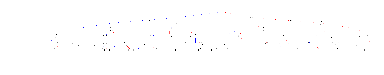

In [6]:
plot_tree(xgb_model, num_trees=0)
plt.show()

### Try to fill in na values

In [ ]:
# df_whole = pd.concat([train_x.iloc[:,1:], valid_x.iloc[:,1:], test.iloc[:,2:]])

# msno.matrix(df_whole[df_whole.columns[df_whole.isnull().any()].tolist()])

In [ ]:
# missing columns analysis for training data

data_positive = data[data['label']==1]
data_negative = data[data['label']==0]
data_unlabeled = data[data['label']==-1]

df_missing_ratio = pd.DataFrame(columns=['positive_missing_ratio', 'negative_missing_ratio',\
                                        'unlabeled_missing_ratio', 'test_missing_ratio'])

for col in data_positive.columns[3:]:
    ratio_1 = data_positive[col].isnull().sum() / data_positive[col].shape[0]
    ratio_2 = data_negative[col].isnull().sum() / data_negative[col].shape[0]
    ratio_3 = data_unlabeled[col].isnull().sum() / data_unlabeled[col].shape[0]
    ratio_4 = test[col].isnull().sum() / test[col].shape[0]
    df_missing_ratio = pd.concat([df_missing_ratio,\
                                  pd.DataFrame(np.array([ratio_1, ratio_2, ratio_3, ratio_4]).reshape((1,4)),\
                                               columns = ['positive_missing_ratio', 'negative_missing_ratio',\
                                                          'unlabeled_missing_ratio', 'test_missing_ratio'])])

df_missing_ratio.index = np.arange(1, df_missing_ratio.index.shape[0]+1)

df_missing_ratio['labeled_missing_ratio'] = \
    (df_missing_ratio['positive_missing_ratio']*data_positive.shape[0]+df_missing_ratio['negative_missing_ratio']*data_negative.shape[0])/\
    (data_positive.shape[0]+data_negative.shape[0])

# save_obj(df_missing_ratio, 'df_missing_ratio')

display_all(df_missing_ratio)

# my_dict = dict()
# my_dict['no_missing_cols'] = selected_cols
# my_dict['num_train'] = num_train
# my_dict['num_test'] = num_test
# save_obj(my_dict, 'my_dict')